In [1]:
# pip install google-play-scraper

# Goal is to create automated system to identify type of problems arising on the app for Bajaj Finserv 

#### Library Imports

In [2]:
# !pip install gensim
# !pip install spacy
# !pip install pyLDAvis --user

In [3]:
import pandas as pd, numpy as np
from google_play_scraper import app
from google_play_scraper import Sort, reviews_all

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import nltk; nltk.download('stopwords')

#OS
import os

C:\Users\sahilmehta\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\sahilmehta\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\sahilmehta\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:169: DeprecationWarning: `np

#### Google play scrapper to scrape all the reviews rated 1,2 and 3 for Bajaj Finserv app
#### We download all the reviews here

In [5]:
result = app('org.altruist.BajajExperia')
# result

In [6]:
# from google_play_scraper import Sort, reviews

# result, continuation_token = reviews(
#     'org.altruist.BajajExperia',
#     lang = 'en',
# #     country='us', # defaults to 'us'
# #     sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
# #     count=3, # defaults to 100
#     filter_score_with=1 # defaults to None(means all score)
# )

In [7]:
result_1 = reviews_all(
    'org.altruist.BajajExperia',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
#     country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    filter_score_with=1 # defaults to None(means all score)
)
result_2 = reviews_all(
    'org.altruist.BajajExperia',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
#     country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    filter_score_with=1 # defaults to None(means all score)
)
result_3 = reviews_all(
    'org.altruist.BajajExperia',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
#     country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    filter_score_with=1 # defaults to None(means all score)
)

In [8]:
result = pd.concat([pd.DataFrame(result_1),pd.DataFrame(result_2),pd.DataFrame(result_3)])

# Data Preprocessing

In [57]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','bajaj','also','do','ki','ka','koi','bhi','hai','ye','aur','aap','kar','ek','ko','ho','kr','tha','hain'])

In [58]:
result.shape

(70923, 10)

In [59]:
result = result[result['content'].str.split().str.len()>2]

In [60]:
# Convert to list
data = result.content.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

In [61]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
# print(data_words[:1])

In [62]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [63]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

In [64]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

In [65]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('app', 1),
  ('imfrob', 1),
  ('keypad', 1),
  ('otp', 2),
  ('receive', 1),
  ('site', 1),
  ('system', 1),
  ('work', 1)]]

In [66]:
# import os
# os.environ.update({'MALLET_HOME':r'C:/Users/sahilmehta/Desktop/Projects/HEART\ Metrics\ for\ Experia/Google\ Reviews/mallet-2.0.8'})

In [67]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'C:/Users/sahilmehta/Desktop/Projects/HEART\ Metrics\ for\ Experia/Google\ Reviews/mallet-2.0.8' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [68]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [69]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=10, step=1)

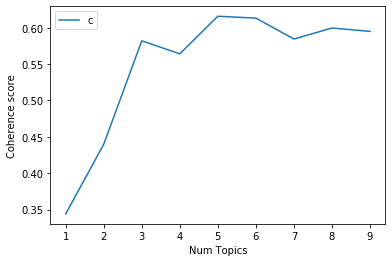

In [70]:
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.051*"service" + 0.048*"bad" + 0.046*"customer" + 0.023*"company" + '
  '0.021*"call" + 0.020*"care" + 0.014*"loan" + 0.013*"finance" + 0.013*"take" '
  '+ 0.012*"finserv"'),
 (1,
  '0.078*"card" + 0.035*"password" + 0.029*"login" + 0.028*"emi" + '
  '0.024*"block" + 0.019*"number" + 0.019*"show" + 0.017*"try" + 0.016*"enter" '
  '+ 0.015*"able"'),
 (2,
  '0.144*"app" + 0.032*"bad" + 0.032*"work" + 0.031*"update" + 0.024*"login" + '
  '0.023*"time" + 0.018*"open" + 0.014*"waste" + 0.012*"version" + '
  '0.011*"new"'),
 (3,
  '0.022*"company" + 0.022*"nahi" + 0.013*"loan" + 0.013*"ke" + 0.012*"chor" + '
  '0.012*"ho" + 0.010*"ko" + 0.008*"finance" + 0.007*"raha" + 0.007*"emi"'),
 (4,
  '0.054*"loan" + 0.030*"emi" + 0.023*"account" + 0.020*"pay" + 0.018*"charge" '
  '+ 0.017*"time" + 0.014*"payment" + 0.013*"get" + 0.013*"take" + '
  '0.013*"month"')]


#### Visualize the Topic 

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.010814  0.215312       1        1  29.533511
4      0.024780  0.153459       2        1  22.545666
2      0.210535 -0.100015       3        1  22.459618
1      0.159473 -0.153857       4        1  13.297711
3     -0.383975 -0.114899       5        1  12.163495, topic_info=         Term          Freq         Total Category  logprob  loglift
1         app  27790.000000  27790.000000  Default  30.0000  30.0000
191      card   8595.000000   8595.000000  Default  29.0000  29.0000
42    service  12708.000000  12708.000000  Default  28.0000  28.0000
172      loan  14247.000000  14247.000000  Default  27.0000  27.0000
89   customer  12251.000000  12251.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
221   finance    736.355871   4682.378761   Topic5  -4.8803   0.2569
50        emi    662.581034   9610.908317   Topic5  -4.9859  -0.5678
12        log    521.009422   2485.883271   Topic5  -5.2263   0.5441
324    charge    539.828493   4744.397681   Topic5  -5.1908  -0.0667
65    finserv    527.061484   4240.820299   Topic5  -5.2147   0.0215

[366 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.009128    able
0         2  0.010702    able
0         3  0.478738    able
0         4  0.501400    able
274       1  0.032091  access
...     ...       ...     ...
239       4  0.995124     करन
245       4  0.994643      नह
246       4  0.987260      पर
250       4  0.996851      रह
3115      4  0.994922      लग

[722 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

IndexError: list index out of range

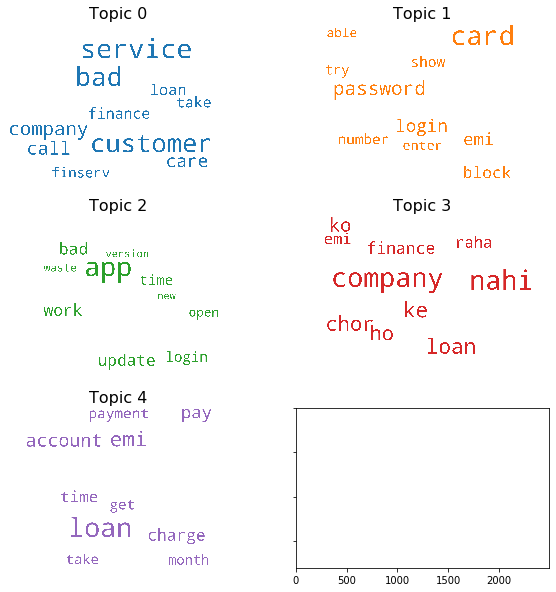

In [73]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i == 4:
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

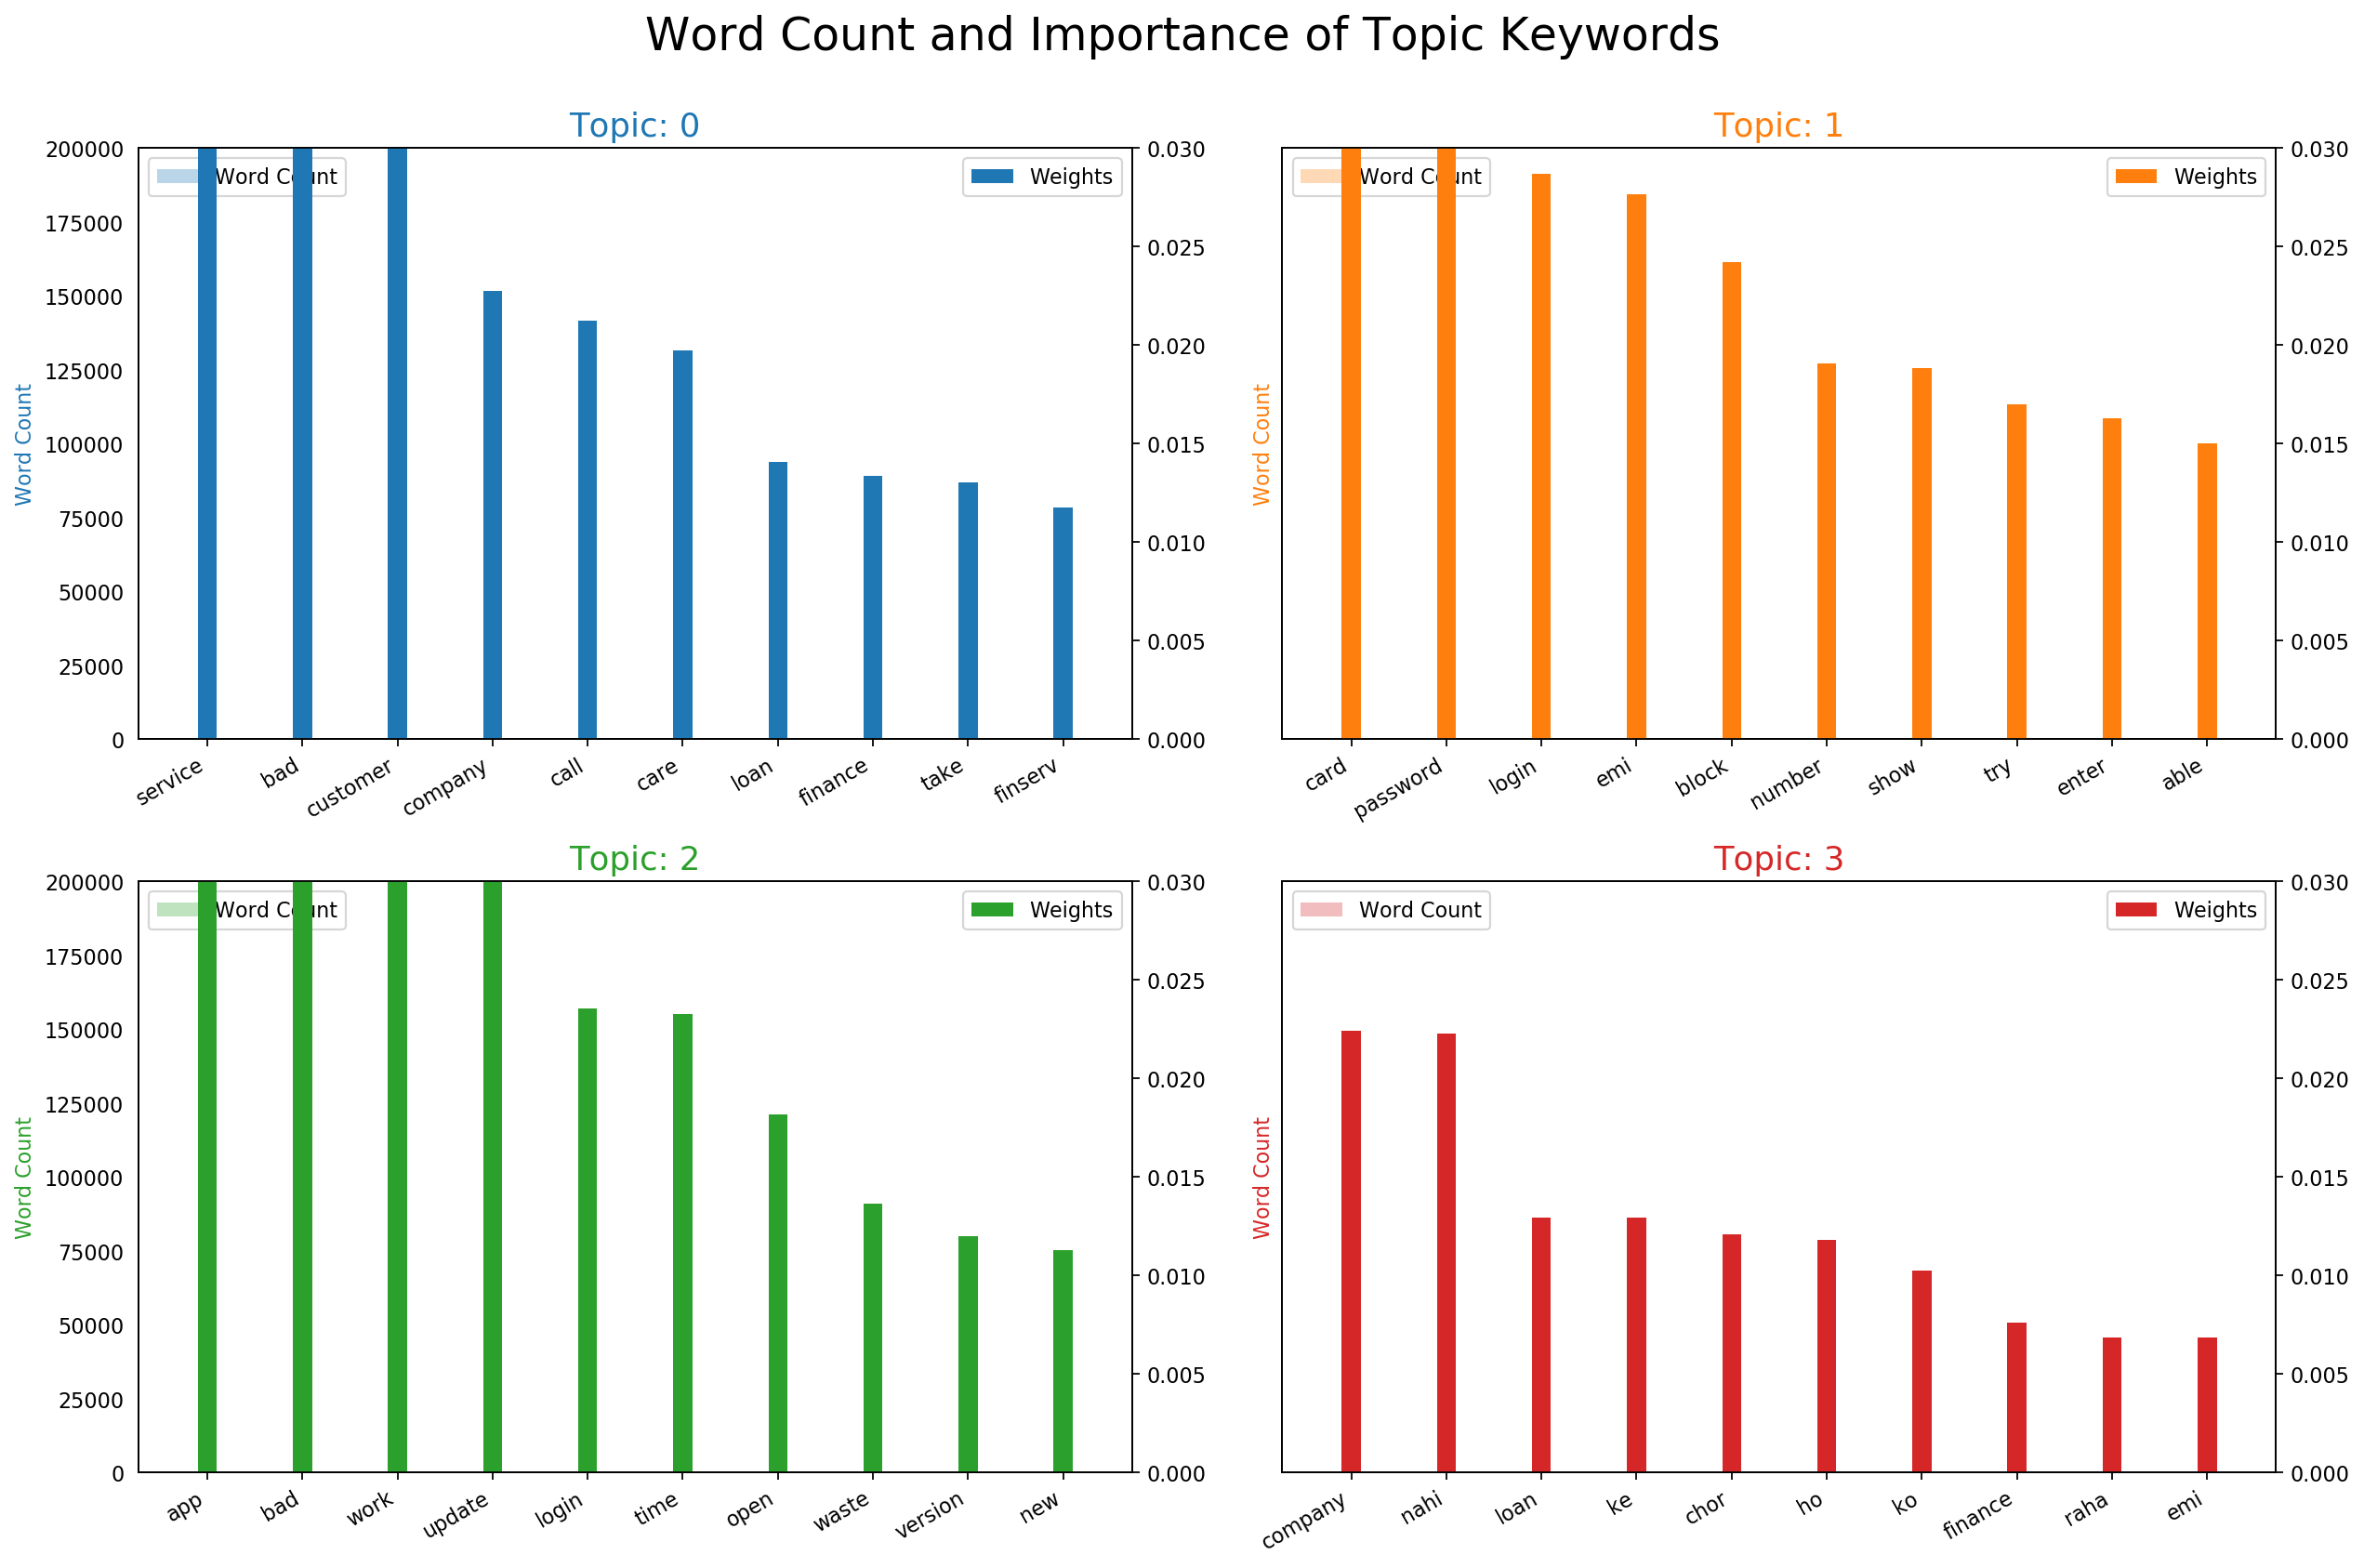

In [79]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 200000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [81]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

TypeError: cannot unpack non-iterable int object